In [147]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from data_analysis_main import perform_tsne
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [148]:
data = pd.read_csv("dataset.csv")
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [149]:
data.isna().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
International                                     0
Curricular u

In [150]:
data.duplicated().sum()

0

In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [152]:
# We trasfer index values for cat values from tables from dataset description
martial_status_map = {
    1: 'Single',
    2: 'Married',
    3: 'Widower',
    4: 'Divorced',
    5: 'Facto Union',
    6: 'Legally Separated'
}
qualification_map = {
    1: '1st phase - general contingent',
    2: 'Ordinance No. 612/93',
    3: '1st phase - special contingent (Azores Island)',
    4: 'Holders of other higher courses',
    5: 'Ordinance No. 854-B/99',
    6: 'International student (bachelor)',
    7: '1st phase - special contingent (Madeira Island)',
    8: '2nd phase - general contingent',
    9: '3rd phase - general contingent',
    10: 'Ordinance No. 533-A/99, item b2) (Different Plan)',
    11: 'Ordinance No. 533-A/99, item b3 (Other Institution)',
    12: 'Over 23 years old',
    13: 'Transfer',
    14: 'Change of course',
    15: 'Technological specialization diploma holders',
    16: 'Change of institution/course',
    17: 'Short cycle diploma holders',
    18: 'Change of institution/course (International)'
}
course_map = {
    1: 'Biofuel Production Technologies',
    2: 'Animation and Multimedia Design',
    3: 'Social Service (evening attendance)',
    4: 'Agronomy',
    5: 'Communication Design',
    6: 'Veterinary Nursing',
    7: 'Informatics Engineering',
    8: 'Equinculture',
    9: 'Management',
    10: 'Social Service',
    11: 'Tourism',
    12: 'Nursing',
    13: 'Oral Hygiene',
    14: 'Advertising and Marketing Management',
    15: 'Journalism and Communication',
    16: 'Basic Education',
    17: 'Management (evening attendance)'
}
attendance_map = {
    1: 'daytime',
    0: 'evening'
}
previous_qual_map = {
    1: 'Secondary education',
    2: "Bachelor's degree",
    3: 'Higher education - degree',
    4: 'Higher education - master\'s',
    5: 'Higher education - doctorate',
    6: 'Frequency of higher education',
    7: '12th year of schooling - not completed',
    8: '11th year of schooling - not completed',
    9: 'Other - 11th year of schooling',
    10: '10th year of schooling',
    11: '10th year of schooling - not completed',
    12: 'Basic education 3rd cycle (9th/10th/11th year) or equiv.',
    13: 'Basic education 2nd cycle (6th/7th/8th year) or equiv.',
    14: 'Technological specialization course',
    15: 'Higher education - degree (1st cycle)',
    16: 'Professional higher technical course',
    17: 'Higher education - master (2nd cycle)'
}
mothers_qual_map = {
    1: 'Secondary Education - 12th Year of Schooling or Eq.',
    2: 'Higher Education - Bachelor\'s Degree',
    3: 'Higher Education - Degree',
    4: 'Higher Education - Master\'s',
    5: 'Higher Education - Doctorate',
    6: 'Frequency of Higher Education',
    7: '12th Year of Schooling - Not Completed',
    8: '11th Year of Schooling - Not Completed',
    9: '7th Year (Old)',
    10: 'Other - 11th Year of Schooling',
    11: '10th Year of Schooling',
    12: 'General commerce course',
    13: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.',
    14: 'Technical-professional course',
    15: '7th year of schooling',
    16: '2nd cycle of the general high school course',
    17: '9th Year of Schooling - Not Completed',
    18: '8th year of schooling',
    19: 'Unknown',
    20: 'Can\'t read or write',
    21: 'Can read without having a 4th year of schooling',
    22: 'Basic education 1st cycle (4th/5th year) or equiv.',
    23: 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.',
    24: 'Technological specialization course',
    25: 'Higher education - degree (1st cycle)',
    26: 'Specialized higher studies course',
    27: 'Professional higher technical course',
    28: 'Higher Education - Master (2nd cycle)',
    29: 'Higher Education - Doctorate (3rd cycle)'
}
mothers_occupation_map = {
    1: 'Student',
    2: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    3: 'Specialists in Intellectual and Scientific Activities',
    4: 'Intermediate Level Technicians and Professions',
    5: 'Administrative staff',
    6: 'Personal Services, Security and Safety Workers and Sellers',
    7: 'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry',
    8: 'Skilled Workers in Industry, Construction and Craftsmen',
    9: 'Installation and Machine Operators and Assembly Workers',
    10: 'Unskilled Workers',
    11: 'Armed Forces Professions',
    12: 'Other Situation',
    13: 'Health professionals',
    14: 'Teachers',
    15: 'Specialists in information and communication technologies (ICT)',
    16: 'Intermediate level science and engineering technicians and professions',
    17: 'Technicians and professionals, of intermediate level of health',
    18: 'Intermediate level technicians from legal, social, sports, cultural and similar services',
    19: 'Office workers, secretaries in general and data processing operators',
    20: 'Data, accounting, statistical, financial services and registry-related operators',
    21: 'Other administrative support staff',
    22: 'Personal service workers',
    23: 'Sellers',
    24: 'Personal care workers and the like',
    25: 'Skilled construction workers and the like, except electricians',
    26: 'Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like',
    27: 'Workers in food processing, woodworking, clothing and other industries and crafts',
    28: 'Cleaning workers',
    29: 'Unskilled workers in agriculture, animal production, fisheries and forestry',
    30: 'Unskilled workers in extractive industry, construction, manufacturing and transport',
    31: 'Meal preparation assistants',
    32: 'Nth'
}
fathers_occupation_map = {
    1: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    2: 'Specialists in Intellectual and Scientific Activities',
    3: 'Intermediate Level Technicians and Professions',
    4: 'Administrative staff',
    5: 'Personal Services, Security and Safety Workers and Sellers',
    6: 'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry',
    7: 'Skilled Workers in Industry, Construction and Craftsmen',
    8: 'Installation and Machine Operators and Assembly Workers',
    9: 'Unskilled Workers',
    10: 'Armed Forces Professions',
    11: 'Directors of administrative and commercial services',
    12: 'Hotel, catering, trade and other services directors',
    13: 'Armed Forces Sergeants',
    14: 'Protection and security services personnel',
    15: 'Specialists in finance, accounting, administrative organization, public and commercial relations',
    16: 'Intermediate level science and engineering technicians and professions',
    17: 'Technicians and professionals, of intermediate level of health',
    18: 'Intermediate level technicians from legal, social, sports, cultural and similar services',
    20: 'Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence',
    21: 'Skilled construction workers and the like, except electricians',
    22: 'Skilled workers in metallurgy, metalworking and similar',
    23: 'Skilled workers in electricity and electronics',
    26: 'Workers in food processing, woodworking, clothing and other industries and crafts',
    27: 'Fixed plant and machine operators',
    28: 'Assembly workers',
    29: 'Vehicle drivers and mobile equipment operators',
    30: 'Unskilled workers in agriculture, animal production, fisheries and forestry',
    31: 'Unskilled workers in extractive industry, construction, manufacturing and transport',
    32: 'Meal preparation assistants',
    33: 'Street vendors (except food) and street service providers',
    35: 'Market-oriented farmers and skilled agricultural and animal production workers',
    36: 'Armed Forces Officers',
    37: 'Other Armed Forces personnel',
    38: 'Health professionals',
    39: 'Teachers',
    40: 'Specialists in the physical sciences, mathematics, engineering and related techniques',
    41: 'Data, accounting, statistical, financial services and registry-related operators',
    42: 'Other administrative support staff',
    43: 'Office workers, secretaries in general and data processing operators',
    44: 'Personal care workers and the like',
    45: 'Personal service workers',
    46: 'Sellers'
}

In [153]:
data['Marital status'] = data['Marital status'].replace(martial_status_map).astype("category")
data['Application mode'] = data['Application mode'].replace(qualification_map).astype("category")
data['Course'] = data['Course'].replace(course_map).astype("category")
data['Daytime/evening attendance'] = data['Daytime/evening attendance'].replace(attendance_map).astype("category")
data['Previous qualification'] = data['Previous qualification'].replace(previous_qual_map).astype("category")
data['Mother\'s qualification'] = data['Mother\'s qualification'].replace(mothers_qual_map).astype("category")
data['Mother\'s occupation'] = data['Mother\'s occupation'].replace(mothers_occupation_map).astype("category")
data['Father\'s occupation'] = data['Father\'s occupation'].replace(fathers_occupation_map).astype("category")
data['Debtor'] = data['Debtor'].replace({1: 'yes', 0: 'no'}).astype("category")
data['Tuition fees up to date'] = data['Tuition fees up to date'].replace({1: 'yes', 0: 'no'}).astype("category")
data['Gender'] = data['Gender'].replace({1: 'male', 0: 'female'}).astype("category")
data['Scholarship holder'] = data['Scholarship holder'].replace({1: 'yes', 0: 'no'}).astype("category")

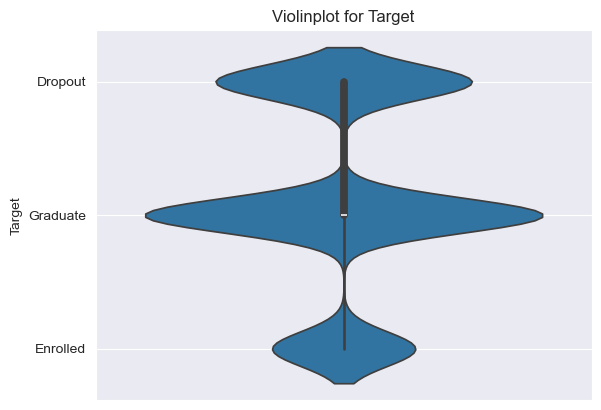

In [154]:
# Violinplot of Target
sns.violinplot(y=data['Target'])
plt.title('Violinplot for Target')
plt.show()

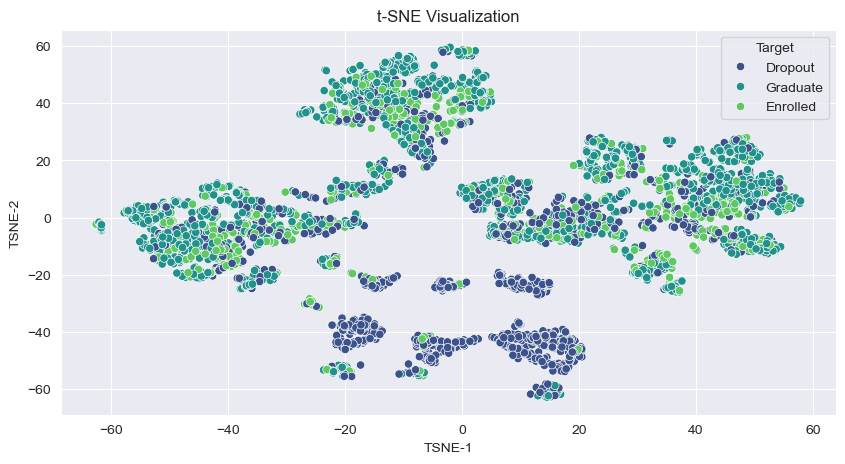

In [155]:
perform_tsne(data)

In [156]:
# The t-SNE plot shows that the Dropout and Enrolled classes overlap somewhat, suggesting that the data for these groups share similar characteristics. However, there are some clusters, such as the dominance of Dropout at the bottom, which may indicate characteristic patterns for this class. Overall, the separation between the classes is not clear, which may make classification difficult.

In [157]:
# We don't need Enrolled to analize dropout rate
data=data[data.Target!='Enrolled']

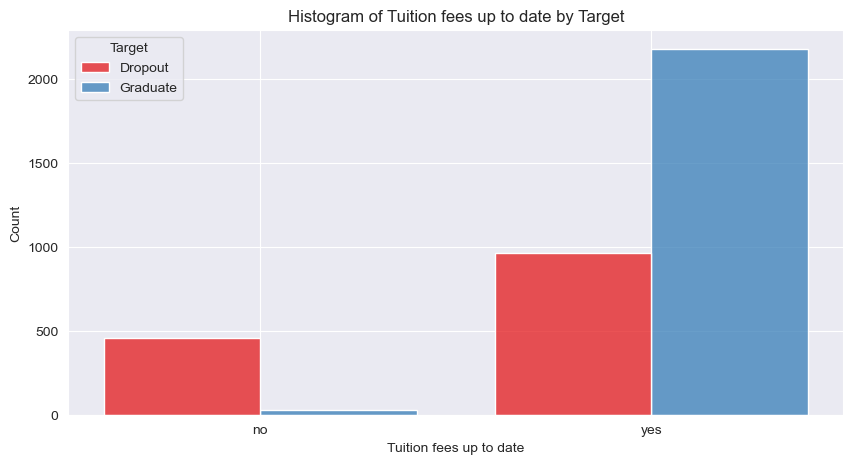

In [158]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='Tuition fees up to date', hue='Target', multiple='dodge', shrink=0.8, palette='Set1')
plt.xlabel('Tuition fees up to date')
plt.ylabel('Count')
plt.title('Histogram of Tuition fees up to date by Target')
plt.show()


In [159]:
# Scholarship holders have more chance to graduate

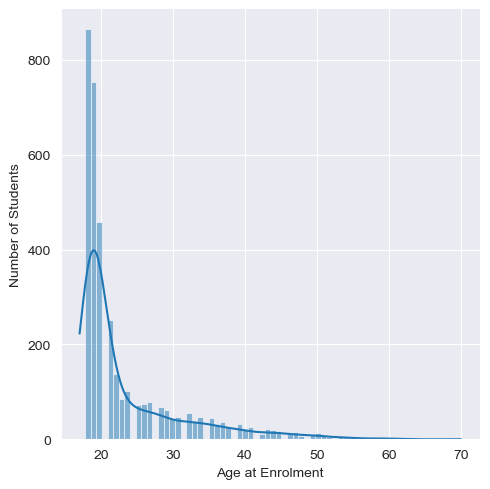

In [160]:
# Age and the academic success of students
sns.displot(data=data, x='Age at enrollment', kde=True)
data['Age at enrollment'].describe()
plt.xlabel('Age at Enrolment')
plt.ylabel('Number of Students')
plt.show()

In [161]:
# The histogram shows that students enroll between the ages [17,70] with majority at age 18-20

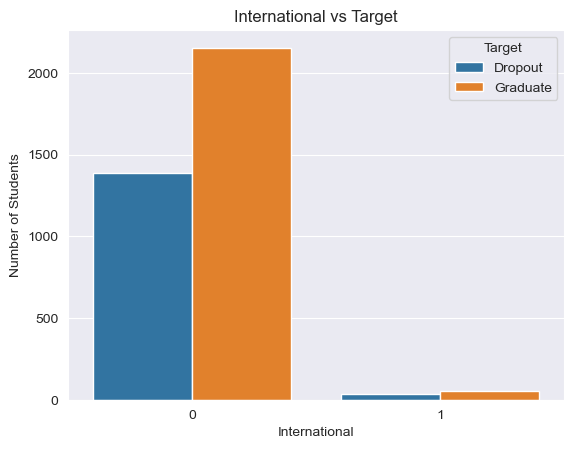

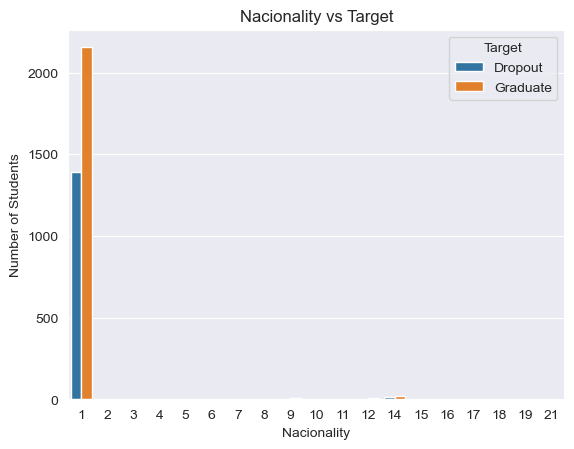

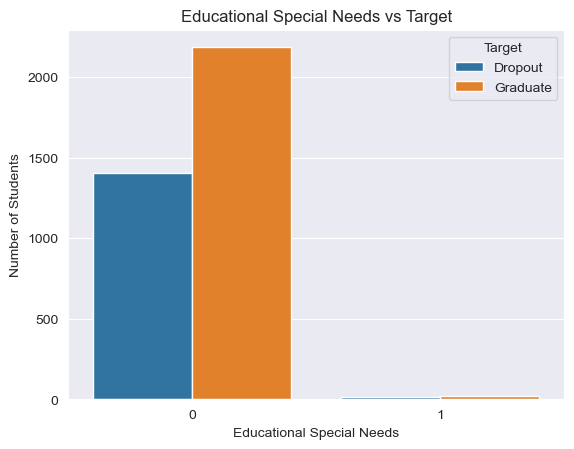

In [162]:
# Histogram for International from Target
sns.countplot(data=data, x='International', hue='Target')
plt.title('International vs Target')
plt.xlabel('International')
plt.ylabel('Number of Students')
plt.legend(title='Target')
plt.show()

# Histogram Nacionality from Targer
sns.countplot(data=data, x='Nacionality', hue='Target')
plt.title('Nacionality vs Target')
plt.xlabel('Nacionality')
plt.ylabel('Number of Students')
plt.legend(title='Target')
plt.show()

sns.countplot(data=data, x='Educational special needs', hue='Target')
plt.title('Educational Special Needs vs Target')
plt.xlabel('Educational Special Needs')
plt.ylabel('Number of Students')
plt.legend(title='Target')
plt.show()

In [163]:
# We can see in these histograms that Nacionality, International, Educational special needs mosty have 1 option so these category doesn't really matter when 
# it comes to analizing dropout rate
# From histograms we find out that: students who graduated and dropped do not have special needs, the data mostly contains students of portugese, which make the highest frequency in nacionality and international
data.drop(['International', 'Nacionality', 'Educational special needs'],axis=1,inplace=True)

In [164]:
encoder = LabelEncoder()
data['Target'] = encoder.fit_transform(data['Target'])

for i, class_label in enumerate(encoder.classes_):
    print(f"{class_label} -> {i}")

Dropout -> 0
Graduate -> 1


In [165]:
columns = [
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Target'
]

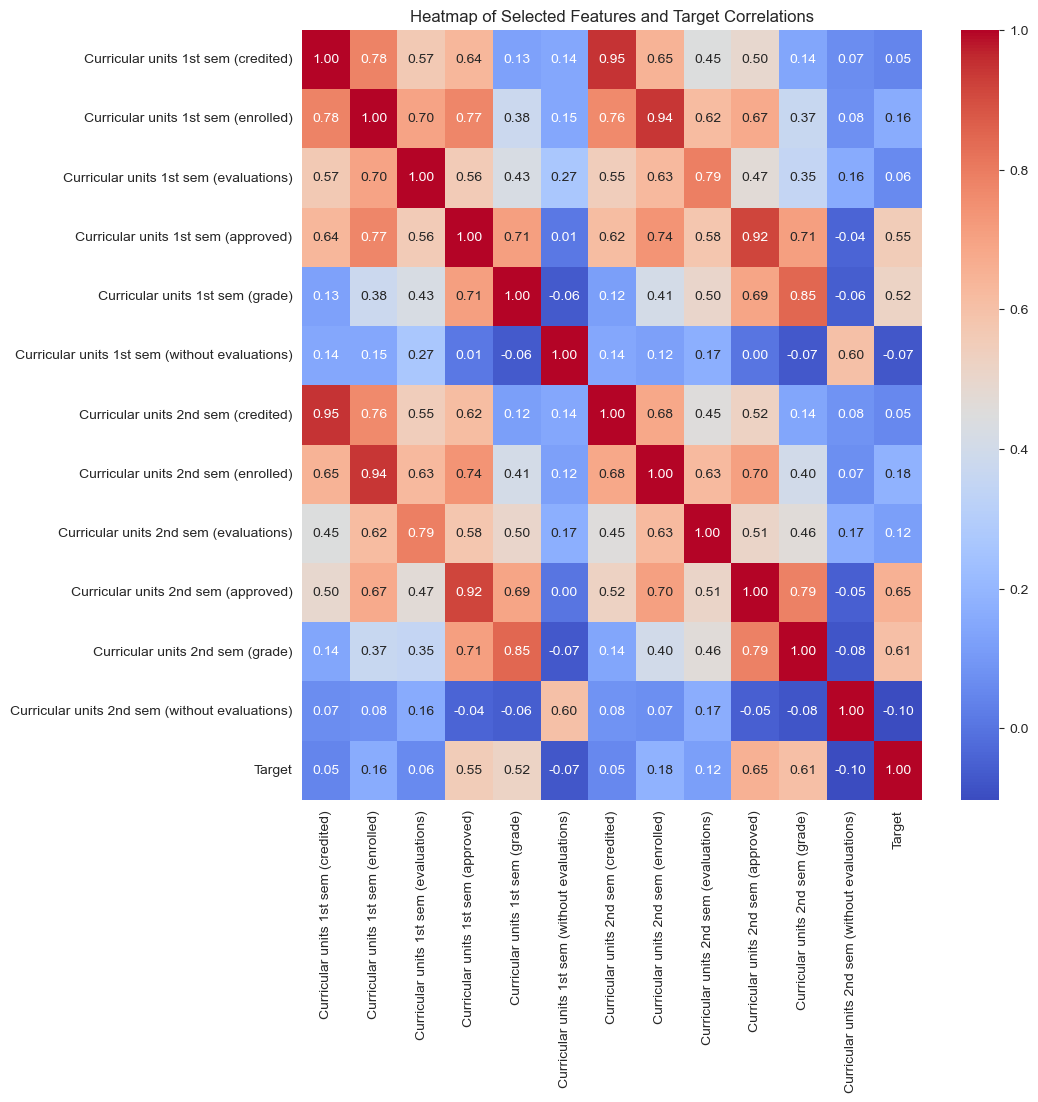

In [166]:
selected_features = data[columns]
plt.figure(figsize=(10, 10))
correlation_matrix = selected_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Selected Features and Target Correlations')
plt.show()

In [167]:
# From this heatman we can see that features from sem 1 and 2 have similar correlations (without Curricular units 1st sem (without evaluations)) so can be removed to reduce redundancy and simplifying 
data.drop(['Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)','Curricular units 1st sem (approved)','Curricular units 1st sem (grade)', 'Curricular units 1st sem (evaluations)'], axis=1, inplace=True)

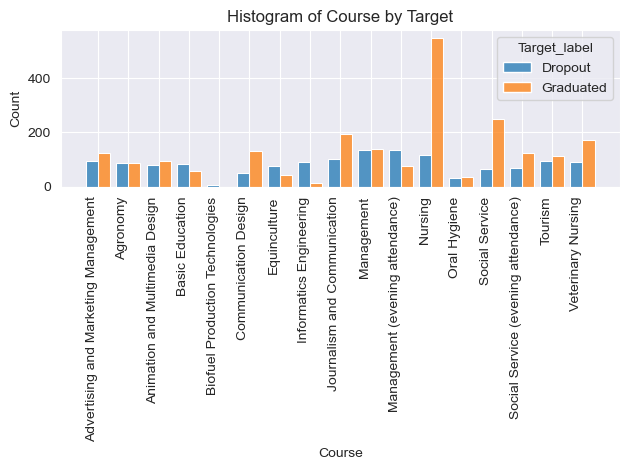

In [168]:
target_labels = {0: 'Dropout', 1: 'Graduated'}
data['Target_label'] = data['Target'].map(target_labels)

sns.histplot(data=data, x='Course', hue='Target_label', multiple='dodge', shrink=0.8)
plt.title('Histogram of Course by Target')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()
data.drop(['Target_label'], axis=1, inplace=True)

In [169]:
# Nursing course have the highest number of graduates while both management courses have the highest number of dropouts

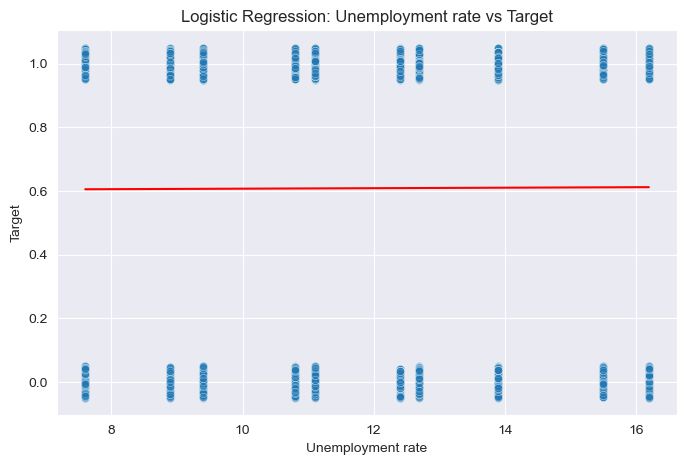

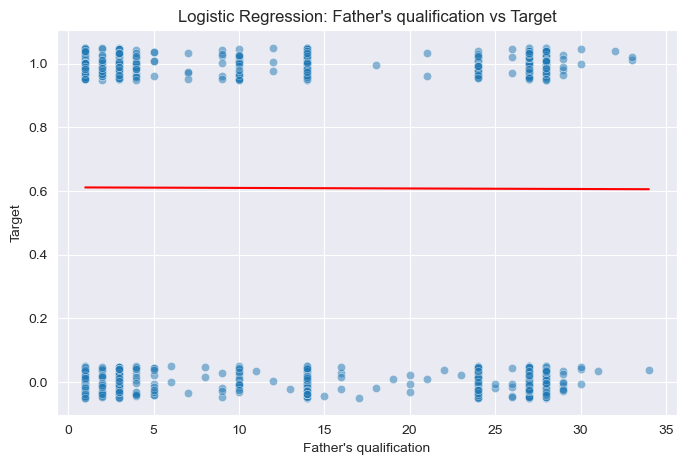

In [170]:
features = ['Unemployment rate', 'Father\'s qualification']

for idx, feature in enumerate(features):
    X = sm.add_constant(data[feature])
    y = data['Target']

    model = sm.Logit(y, X)
    result = model.fit(disp=0)

    b0 = result.params['const']
    b1 = result.params[feature]

    x_vals = np.linspace(data[feature].min(), data[feature].max(), 300)
    logits = b0 + b1 * x_vals
    probs = 1 / (1 + np.exp(-logits))

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=data[feature], y=data['Target'] + np.random.uniform(-0.05, 0.05, size=len(data)), alpha=0.5)
    plt.plot(x_vals, probs, color='red')
    plt.title(f'Logistic Regression: {feature} vs Target')
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.show()


In [171]:
# As we see Father's qualification and Unemployment rate suggests there’s no significant relationship between the predictor variable and the outcome variable.
data.drop(['Unemployment rate', 'Father\'s qualification'], axis=1, inplace=True)

In [172]:
X = data.drop('Target', axis=1)
y = data['Target']

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])

models = {
    # "Linear Regression": LinearRegression(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42), 
    "SVM": SVC() 
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 


Training Accuracy of Logistic Regression: 0.9205
Training Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89      1144
           1       0.91      0.97      0.94      1760

    accuracy                           0.92      2904
   macro avg       0.93      0.91      0.92      2904
weighted avg       0.92      0.92      0.92      2904

Test Accuracy of Logistic Regression: 0.9105
Test Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88       277
           1       0.91      0.95      0.93       449

    accuracy                           0.91       726
   macro avg       0.91      0.90      0.90       726
weighted avg       0.91      0.91      0.91       726



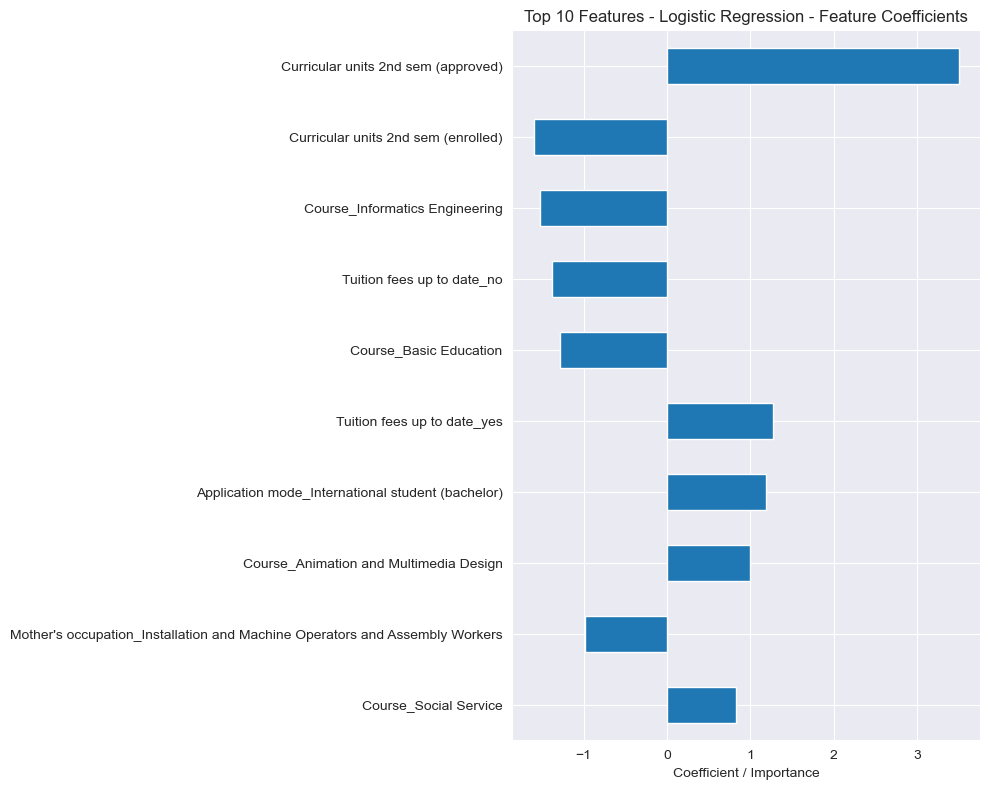

-------------------------------------------------------
Training Accuracy of RandomForest: 1.0000
Training Classification Report for RandomForest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1144
           1       1.00      1.00      1.00      1760

    accuracy                           1.00      2904
   macro avg       1.00      1.00      1.00      2904
weighted avg       1.00      1.00      1.00      2904

Test Accuracy of RandomForest: 0.8926
Test Classification Report for RandomForest:
               precision    recall  f1-score   support

           0       0.91      0.79      0.85       277
           1       0.88      0.95      0.92       449

    accuracy                           0.89       726
   macro avg       0.90      0.87      0.88       726
weighted avg       0.89      0.89      0.89       726



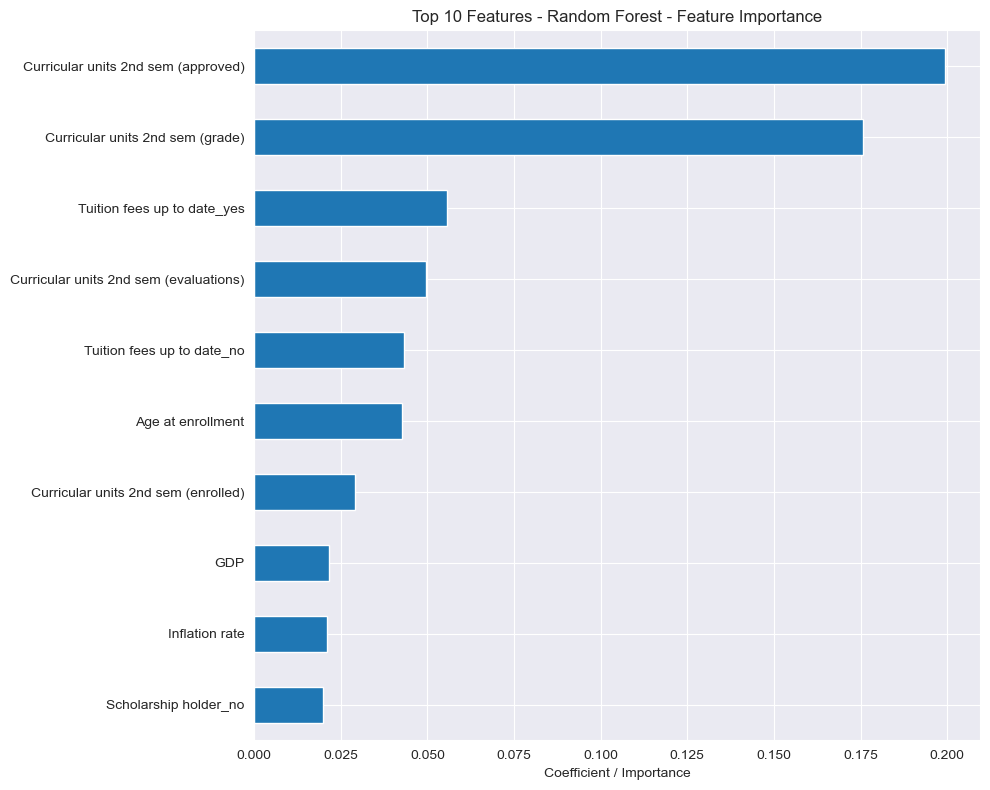

-------------------------------------------------------
Training Accuracy of SVM: 0.9353
Training Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.97      0.86      0.91      1144
           1       0.91      0.98      0.95      1760

    accuracy                           0.94      2904
   macro avg       0.94      0.92      0.93      2904
weighted avg       0.94      0.94      0.93      2904

Test Accuracy of SVM: 0.8939
Test Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.92      0.79      0.85       277
           1       0.88      0.96      0.92       449

    accuracy                           0.89       726
   macro avg       0.90      0.87      0.88       726
weighted avg       0.90      0.89      0.89       726

-------------------------------------------------------


In [173]:
for model_name, model in models.items():
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    clf.fit(X_train, y_train)
    
    y_train_pred = clf.predict(X_train)
    print(f"Training Accuracy of {model_name}: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Training Classification Report for {model_name}:\n", classification_report(y_train, y_train_pred))
    
    y_test_pred = clf.predict(X_test)
    print(f"Test Accuracy of {model_name}: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Test Classification Report for {model_name}:\n", classification_report(y_test, y_test_pred))

    cat_features = clf.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
    all_features = np.concatenate([numerical_cols, cat_features])
    
    if model_name == "RandomForest":
        importances = clf.named_steps['classifier'].feature_importances_
        feature_importance = pd.Series(importances, index=all_features).sort_values(ascending=False)
        title = "Random Forest - Feature Importance"
        
    elif model_name == "Logistic Regression":
        coefs = clf.named_steps['classifier'].coef_[0]
        feature_importance = pd.Series(coefs, index=all_features).sort_values(key=abs, ascending=False)
        title = "Logistic Regression - Feature Coefficients"
        
    else:
        feature_importance = None  

    if feature_importance is not None:
        plt.figure(figsize=(10, 8))
        feature_importance.head(10).plot(kind='barh')
        plt.xlabel("Coefficient / Importance")
        plt.title(f"Top 10 Features - {title}")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    print("-" * 55)

In [174]:
models_filtered = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "SVM": SVC()
}

for model_name, model in models_filtered.items():
    clf = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    print(f"Training Accuracy with SMOTE of {model_name}: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Training Classification Report for {model_name}:\n", classification_report(y_train, y_train_pred))

    y_test_pred = clf.predict(X_test)
    print(f"Test Accuracy with SMOTE of {model_name}: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Test Classification Report for {model_name}:\n", classification_report(y_test, y_test_pred))

Training Accuracy with SMOTE of RandomForest: 1.0000
Training Classification Report for RandomForest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1144
           1       1.00      1.00      1.00      1760

    accuracy                           1.00      2904
   macro avg       1.00      1.00      1.00      2904
weighted avg       1.00      1.00      1.00      2904

Test Accuracy with SMOTE of RandomForest: 0.8884
Test Classification Report for RandomForest:
               precision    recall  f1-score   support

           0       0.89      0.81      0.85       277
           1       0.89      0.94      0.91       449

    accuracy                           0.89       726
   macro avg       0.89      0.87      0.88       726
weighted avg       0.89      0.89      0.89       726

Training Accuracy with SMOTE of SVM: 0.9373
Training Classification Report for SVM:
               precision    recall  f1-score   support

        

In [175]:
# After applying SMOTE, the class balance in the training data improved, leading to slightly more balanced precision and recall scores across all models. SVM showed a small drop in test accuracy but gained better recall for the minority class, indicating improved sensitivity. Random Forest remained overfitted on the training set (100% accuracy), and its test performance stayed relatively stable, with a slight increase in recall for the minority class. Overall, SMOTE helped mitigate class imbalance without significantly harming model generalization.

In [176]:
# Hyperparameter tuning for SVM
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],           
    'classifier__kernel': ['linear', 'rbf'], 
    'classifier__gamma': ['scale', 'auto']   # gamma parameter for rbf kernel
}

svm_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC())
])

grid_search_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    scoring='accuracy',
    cv=3,
    n_jobs=-1, # use all avaliable CPU
    verbose=1 # about how much message during the search
)

grid_search_svm.fit(X_train, y_train)

print("Best parameters found for SVM:")
print(grid_search_svm.best_params_)

# Evaluate on training set
best_svm = grid_search_svm.best_estimator_
y_train_pred_best_svm = best_svm.predict(X_train)
print(f"Training Accuracy of optimized SVM: {accuracy_score(y_train, y_train_pred_best_svm):.4f}")
print(f"Training Classification Report of optimized SVM:\n{classification_report(y_train, y_train_pred_best_svm)}")

# Evaluate on test set
y_test_pred_best_svm = best_svm.predict(X_test)
print(f"Test Accuracy of optimized SVM: {accuracy_score(y_test, y_test_pred_best_svm):.4f}")
print(f"Test Classification Report of optimized SVM:\n{classification_report(y_test, y_test_pred_best_svm)}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters found for SVM:
{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Training Accuracy of optimized SVM: 0.9373
Training Classification Report of optimized SVM:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1144
           1       0.94      0.96      0.95      1760

    accuracy                           0.94      2904
   macro avg       0.94      0.93      0.93      2904
weighted avg       0.94      0.94      0.94      2904

Test Accuracy of optimized SVM: 0.8912
Test Classification Report of optimized SVM:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       277
           1       0.90      0.93      0.91       449

    accuracy                           0.89       726
   macro avg       0.89      0.88      0.88       726
weighted avg       0.89      0.89      0.89       726

In [177]:
# The GridSearchCV successfully identified the best SVM hyperparameters (C=1, gamma='scale', kernel='rbf'), which led to strong training performance with an accuracy of 93.7%. The model achieves a good balance between precision and recall, especially for the positive class. 


No Regularization:
Train Accuracy (PolynomialFeatures): 0.9249
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1144
           1       0.91      0.97      0.94      1760

    accuracy                           0.92      2904
   macro avg       0.93      0.91      0.92      2904
weighted avg       0.93      0.92      0.92      2904

Test Accuracy (PolynomialFeatures): 0.9105
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       277
           1       0.91      0.95      0.93       449

    accuracy                           0.91       726
   macro avg       0.91      0.90      0.90       726
weighted avg       0.91      0.91      0.91       726


Ridge (L2):
Train Accuracy (PolynomialFeatures): 0.9205
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.94      0.85  

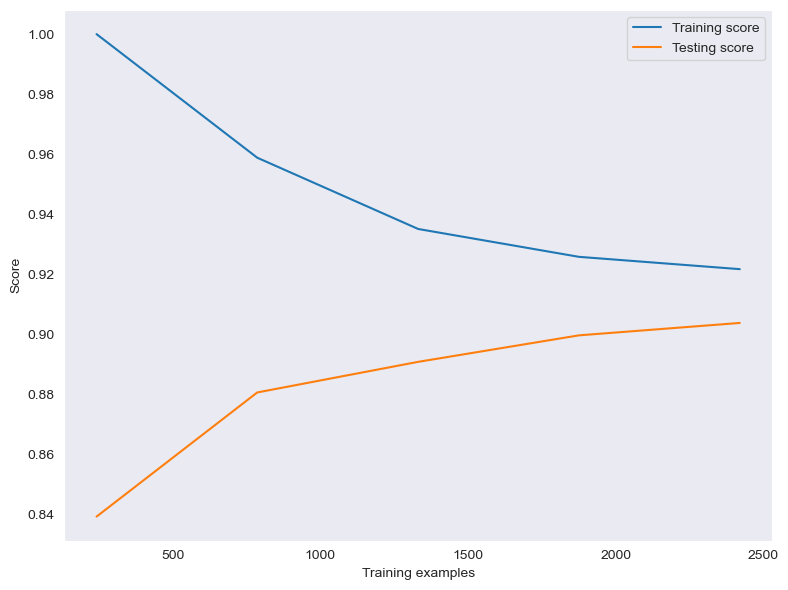

In [178]:
numeric_with_poly = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ('scaler', StandardScaler())
])


poly_preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_with_poly, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])

# Pipeline without regulations
clf_none = Pipeline(steps=[
    ('preprocessor', poly_preprocessor),
    ('classifier', LogisticRegression(C=1e10, penalty='l2', solver='lbfgs', max_iter=1000))  # C must be high for almost zero l2 regulation
])


# Lasso (L1)
clf_lasso = Pipeline(steps=[
    ('preprocessor', poly_preprocessor),
    ('classifier', LogisticRegression(C=1.0, penalty='l1', solver='liblinear', max_iter=1000))
])

# Ridge (L2)
clf_ridge = Pipeline(steps=[
    ('preprocessor', poly_preprocessor),
    ('classifier', LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', max_iter=1000))
])

models = {
    "No Regularization": clf_none,
    "Ridge (L2)": clf_ridge,
    "Lasso (L1)": clf_lasso
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred_poly = model.predict(X_train)
    y_test_pred_poly = model.predict(X_test)
    print(f"\n{name}:")
    print(f"Train Accuracy (PolynomialFeatures): {accuracy_score(y_train, y_train_pred_poly):.4f}")
    print(f"Classification Report (Train):\n{classification_report(y_train, y_train_pred_poly)}")
    print(f"Test Accuracy (PolynomialFeatures): {accuracy_score(y_test, y_test_pred_poly):.4f}")
    print(f"Classification Report (Test):\n{classification_report(y_test, y_test_pred_poly)}")


train_sizes, train_scores, test_scores = learning_curve(
    clf_none, X, y, cv=3, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Testing score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()  

In [179]:
# The model with polynomial features of degree 1 achieves higher test accuracy (91.05%) compared to the degree 2 model (89.94%), indicating better generalization to unseen data.
# A degree 1 model provides similar performance with a simpler structure, while also reducing the risk of overfitting observed in the degree 2 model.


In [180]:
clf_none_smote = ImbPipeline(steps=[
    ('preprocessor', poly_preprocessor),  # uses PolynomialFeatures(degree=1)
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(C=1, penalty=None, solver='lbfgs', max_iter=1000))
])

# Fit and evaluate
clf_none_smote.fit(X_train, y_train)
y_train_pred_smote = clf_none_smote.predict(X_train)
y_test_pred_smote = clf_none_smote.predict(X_test)

print("\nLogistic Regression with SMOTE (No Regularization):")
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred_smote):.4f}")
print(f"Classification Report (Train):\n{classification_report(y_train, y_train_pred_smote)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred_smote):.4f}")
print(f"Classification Report (Test):\n{classification_report(y_test, y_test_pred_smote)}")


Logistic Regression with SMOTE (No Regularization):
Train Accuracy: 0.9194
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1144
           1       0.93      0.94      0.93      1760

    accuracy                           0.92      2904
   macro avg       0.92      0.91      0.92      2904
weighted avg       0.92      0.92      0.92      2904

Test Accuracy: 0.9036
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       277
           1       0.91      0.93      0.92       449

    accuracy                           0.90       726
   macro avg       0.90      0.90      0.90       726
weighted avg       0.90      0.90      0.90       726



In [181]:
# The Logistic Regression model without SMOTE achieved slightly higher accuracy and f1-scores on both training and test sets compared to the version with SMOTE. This indicates that, for this dataset, applying SMOTE did not significantly improve performance and the model generalizes well without oversampling.

In [182]:
logistic_models = {
    "No Regularization": clf_none,
    "Ridge (L2)": clf_ridge,
    "Lasso (L1)": clf_lasso,
    "No Regularization + SMOTE": clf_none_smote
}

for name, model in logistic_models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print(f"\n==================== {name} ====================")
    print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Training Classification Report:\n", classification_report(y_train, y_train_pred))

    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Test Classification Report:\n", classification_report(y_test, y_test_pred))


==================== No Regularization ====================
Training Accuracy: 0.9249311294765841
Training Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90      1144
           1       0.91      0.97      0.94      1760

    accuracy                           0.92      2904
   macro avg       0.93      0.91      0.92      2904
weighted avg       0.93      0.92      0.92      2904

Test Accuracy: 0.9104683195592287
Test Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88       277
           1       0.91      0.95      0.93       449

    accuracy                           0.91       726
   macro avg       0.91      0.90      0.90       726
weighted avg       0.91      0.91      0.91       726


==================== Ridge (L2) ====================
Training Accuracy: 0.9204545454545454
Training Classification Report:
               precision   

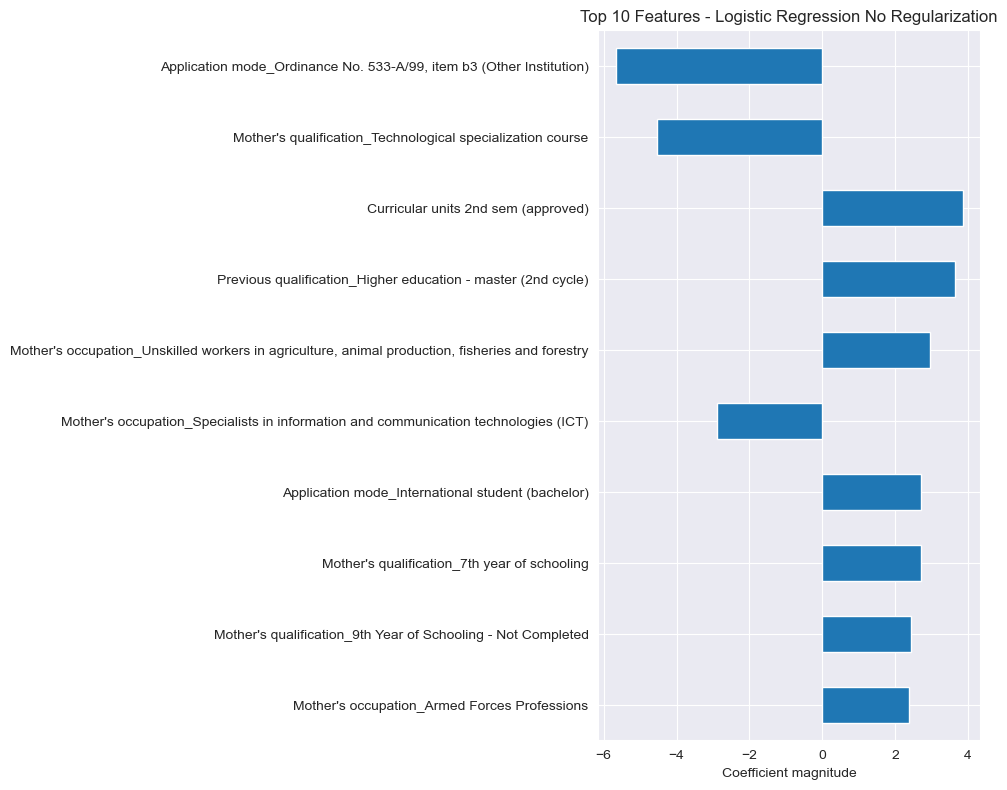

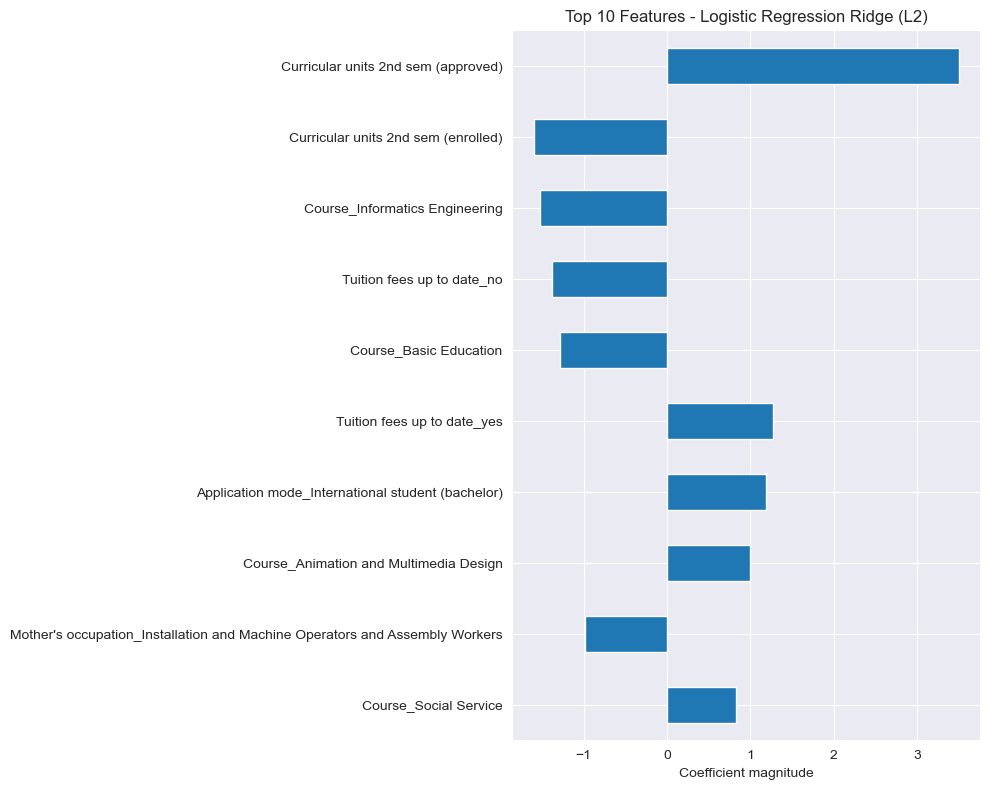

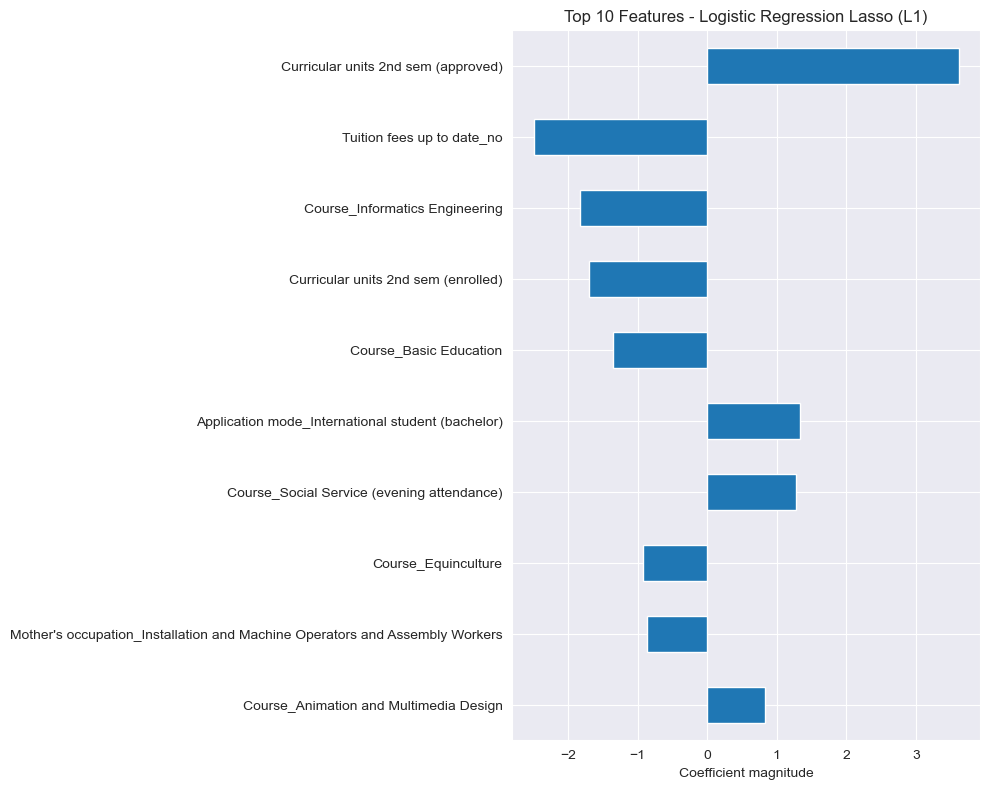

In [183]:
def plot_top_features(clf, numerical_cols, categorical_cols, title_suffix=""):
    preprocessor = clf.named_steps['preprocessor']
    classifier = clf.named_steps['classifier']

    num_transformer = preprocessor.named_transformers_['num']
    poly = num_transformer.named_steps['poly']
    poly_feature_names = poly.get_feature_names_out(numerical_cols)

    cat_transformer = preprocessor.named_transformers_['cat']
    if hasattr(cat_transformer, 'named_steps'):
        last_step = cat_transformer.named_steps[list(cat_transformer.named_steps.keys())[-1]]
    else:
        last_step = cat_transformer

    if hasattr(last_step, 'get_feature_names_out'):
        cat_feature_names = last_step.get_feature_names_out(categorical_cols)
    else:
        cat_feature_names = categorical_cols

    all_features = list(poly_feature_names) + list(cat_feature_names)
    coefs = classifier.coef_[0]
    feature_importance = pd.Series(coefs, index=all_features).sort_values(key=abs, ascending=False)

    plt.figure(figsize=(10, 8))
    feature_importance.head(10).plot(kind='barh')
    plt.xlabel("Coefficient magnitude")
    plt.title(f"Top 10 Features - Logistic Regression {title_suffix}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_top_features(clf_none, numerical_cols, categorical_cols, "No Regularization")
plot_top_features(clf_ridge, numerical_cols, categorical_cols, "Ridge (L2)")
plot_top_features(clf_lasso, numerical_cols, categorical_cols, "Lasso (L1)")

In [184]:
# Features like "Curricular units 2nd sem (approved)" consistently rank highly across all models but their coefficients shrink with regularization. No Regularization: Extreme coefficient values e.g. -6  suggest overfitting to rare/noisy patterns. L2 (Ridge): Retains all features but reduces their influence. L1 (Lasso): Aggressively shrinks coefficients but retains top features, prioritizing simplicity without fully eliminating them here.

In [185]:
# Grid for Logistic regression
clf_smote = ImbPipeline(steps=[
    ('preprocessor', poly_preprocessor),  # PolynomialFeatures(degree=1)
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000))
])

param_grid = [
    {
        'classifier__penalty': [None],
        'classifier__solver': ['lbfgs', 'newton-cg', 'sag'],
        'classifier__C': [1],  
    },
    {
        'classifier__penalty': ['l1', 'elasticnet'],
        'classifier__solver': ['saga'],
        'classifier__C': [0.01, 0.1, 1, 10, 1e10],
        'classifier__l1_ratio': [0.0, 0.5, 1.0],  
    },
    {
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs', 'saga', 'newton-cg', 'sag'],
        'classifier__C': [0.01, 0.1, 1, 10, 1e10],
    }
]

# Setup GridSearchCV
grid_search = GridSearchCV(
    clf_smote,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

best_clf = grid_search.best_estimator_

y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)

print("\nTraining Accuracy of optimized Logistic Regression:", accuracy_score(y_train, y_train_pred))
print("Training Classification Report:\n", classification_report(y_train, y_train_pred))

print("Test Accuracy of optimized Logistic Regression:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Fitting 3 folds for each of 53 candidates, totalling 159 fits
Best parameters found:
{'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best cross-validation accuracy: 0.9053

Training Accuracy of optimized Logistic Regression: 0.9070247933884298
Training Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      1144
           1       0.92      0.93      0.92      1760

    accuracy                           0.91      2904
   macro avg       0.90      0.90      0.90      2904
weighted avg       0.91      0.91      0.91      2904

Test Accuracy of optimized Logistic Regression: 0.9035812672176309
Test Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87       277
           1       0.91      0.94      0.92       449

    accuracy                           0.90       726
   macro avg       0.90      0.89      0.90    

In [186]:
# The grid search identified the best Logistic Regression model with L2 regularization (penalty='l2') and C=0.1, achieving a balanced trade-off between bias and variance. The model performs well on both training and test sets, showing strong precision and recall, indicating effective generalization without overfitting.

In [187]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, theta, lambda_=0.0):
    m = len(y)
    h = sigmoid(X @ theta)
    epsilon = 1e-10  # avoid log(0)
    reg_term = (lambda_ / (2 * m)) * np.sum(np.square(theta[1:]))  # exclude bias
    cost = (-1 / m) * (y.T @ np.log(h + epsilon) + (1 - y).T @ np.log(1 - h + epsilon)) + reg_term
    return cost.flatten()[0]

def logistic_regression_gd(X_train, y_train, X_val, y_val, lr=0.1, epochs=1000, lambda_=0.0): # Labda is like a regulrization for model and it uses l2 penalty methode for high values of weights 
    m, n = X_train.shape
    X_train = np.hstack([np.ones((m, 1)), X_train])  # add bias
    m_val = X_val.shape[0]
    X_val = np.hstack([np.ones((m_val, 1)), X_val])  # add bias
    
    theta = np.zeros((n + 1, 1))
    train_costs = []
    val_costs = []
    
    for _ in range(epochs):
        z = X_train @ theta
        predictions = sigmoid(z)
        error = predictions - y_train
        gradient = (1 / m) * X_train.T @ error
        
        # Regularization (excluding bias term from regularization)
        reg = (lambda_ / m) * theta
        reg[0] = 0  # don't regularize bias term
        
        theta -= lr * (gradient + reg)
        
        train_costs.append(compute_cost(X_train, y_train, theta, lambda_))
        val_costs.append(compute_cost(X_val, y_val, theta, lambda_))
        
    return theta, train_costs, val_costs


In [188]:
X_np = X_train[numerical_cols].to_numpy()
y_np = y_train.to_numpy().reshape(-1, 1)
X_test_np = X_test[numerical_cols].to_numpy()
y_test_np = y_test.to_numpy().reshape(-1, 1)

theta, train_costs, val_costs = logistic_regression_gd(X_np, y_np, X_test_np, y_test_np, lr=0.05, epochs=2000, lambda_=0.0)

# Ewaluacja modelu na zbiorze testowym
X_test_bias = np.hstack([np.ones((X_test_np.shape[0], 1)), X_test_np])
y_prob = sigmoid(X_test_bias @ theta)
y_pred = (y_prob >= 0.5).astype(int)

print("Test Accuracy of logistic regression:", accuracy_score(y_test_np, y_pred))
print("Test Classification Report:\n", classification_report(y_test_np, y_pred))

# Ewaluacja na zbiorze treningowym
X_train_np = np.hstack([np.ones((X_np.shape[0], 1)), X_np])
y_train_pred_prob = sigmoid(X_train_np @ theta)
y_train_pred = (y_train_pred_prob >= 0.5).astype(int)   

print("\nTraining Accuracy of logistic regression:", accuracy_score(y_np, y_train_pred))
print("Training Classification Report:\n", classification_report(y_np, y_train_pred))

Test Accuracy of logistic regression: 0.849862258953168
Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.63      0.76       277
           1       0.81      0.98      0.89       449

    accuracy                           0.85       726
   macro avg       0.89      0.81      0.83       726
weighted avg       0.87      0.85      0.84       726


Training Accuracy of logistic regression: 0.8632920110192838
Training Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.67      0.79      1144
           1       0.82      0.99      0.90      1760

    accuracy                           0.86      2904
   macro avg       0.90      0.83      0.85      2904
weighted avg       0.88      0.86      0.86      2904



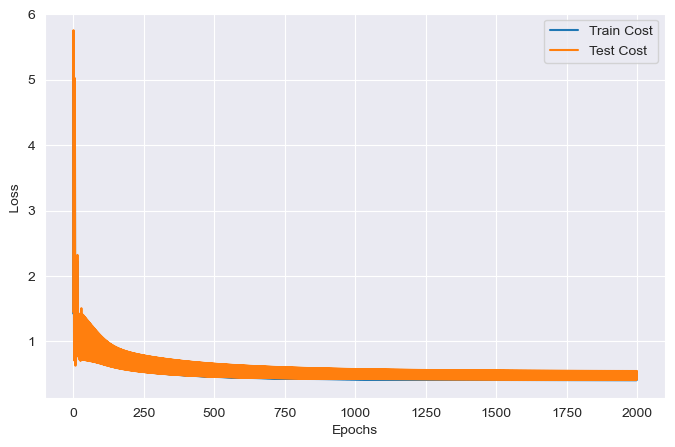

In [189]:
# Diagram loss of epochs
plt.figure(figsize=(8,5))
plt.plot(train_costs, label='Train Cost')
plt.plot(val_costs, label='Test Cost')
plt.xlabel('Epochs')
plt.ylabel('    Loss')
plt.legend()
plt.grid(True)
plt.show()

In [190]:
# The log loss for both training and test sets steadily decreases and stabilizes over epochs, indicating consistent learning without significant overfitting.
# Adding additional features increase the log loss for about 2 and also the train cost is slightly higher than test

In [191]:
# Cross-validation setup
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold = 1
cv_accuracies = []

for train_idx, val_idx in skf.split(X_np, y_np):
    X_fold_train, X_fold_val = X_np[train_idx], X_np[val_idx]
    y_fold_train, y_fold_val = y_np[train_idx], y_np[val_idx]

    # Train model
    theta, _, _ = logistic_regression_gd(X_fold_train, y_fold_train, X_fold_val, y_fold_val, lr=0.05, epochs=2000, lambda_=0.0)

    # Evaluate on validation set
    X_val_bias = np.hstack([np.ones((X_fold_val.shape[0], 1)), X_fold_val])
    y_val_pred_prob = sigmoid(X_val_bias @ theta)
    y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

    acc = accuracy_score(y_fold_val, y_val_pred)
    cv_accuracies.append(acc)

    print(f"Fold {fold} Validation Accuracy: {acc:.4f}")
    print(f"Fold {fold} Validation Classification Report:\n", classification_report(y_fold_val, y_val_pred))

    # Evaluate on training set
    X_train_bias = np.hstack([np.ones((X_fold_train.shape[0], 1)), X_fold_train])
    y_train_pred_prob = sigmoid(X_train_bias @ theta)
    y_train_pred = (y_train_pred_prob >= 0.5).astype(int)

    train_acc = accuracy_score(y_fold_train, y_train_pred)
    print(f"Fold {fold} Training Accuracy: {train_acc:.4f}")
    print(f"Fold {fold} Training Classification Report:\n", classification_report(y_fold_train, y_train_pred))

    fold += 1

# Average CV accuracy
print(f"Average CV Accuracy: {np.mean(cv_accuracies):.4f}")

Fold 1 Validation Accuracy: 0.8605
Fold 1 Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.67      0.79       382
           1       0.82      0.99      0.90       586

    accuracy                           0.86       968
   macro avg       0.89      0.83      0.84       968
weighted avg       0.88      0.86      0.85       968

Fold 1 Training Accuracy: 0.8642
Fold 1 Training Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.67      0.80       762
           1       0.82      0.99      0.90      1174

    accuracy                           0.86      1936
   macro avg       0.90      0.83      0.85      1936
weighted avg       0.88      0.86      0.86      1936

Fold 2 Validation Accuracy: 0.8574
Fold 2 Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.65      0.78       381
          

In [192]:
# The cross-validation results show consistent performance across all three folds, with validation accuracies around 80–82% and training accuracies close to 81%, indicating a well-generalizing model. The model performs slightly better on class 0 in terms of precision but shows higher recall for class 1, suggesting a balanced ability to detect both classes.

In [193]:
# Cross-validation setup with l2 
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold = 1
cv_accuracies = []

for train_idx, val_idx in skf.split(X_np, y_np):
    X_fold_train, X_fold_val = X_np[train_idx], X_np[val_idx]
    y_fold_train, y_fold_val = y_np[train_idx], y_np[val_idx]

    # Train model
    theta, _, _ = logistic_regression_gd(X_fold_train, y_fold_train, X_fold_val, y_fold_val, lr=0.05, epochs=2000, lambda_=0.45)

    # Evaluate on validation set
    X_val_bias = np.hstack([np.ones((X_fold_val.shape[0], 1)), X_fold_val])
    y_val_pred_prob = sigmoid(X_val_bias @ theta)
    y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

    acc = accuracy_score(y_fold_val, y_val_pred)
    cv_accuracies.append(acc)

    print(f"Fold {fold} Validation Accuracy: {acc:.4f}")
    print(f"Fold {fold} Validation Classification Report:\n", classification_report(y_fold_val, y_val_pred))

    # Evaluate on training set
    X_train_bias = np.hstack([np.ones((X_fold_train.shape[0], 1)), X_fold_train])
    y_train_pred_prob = sigmoid(X_train_bias @ theta)
    y_train_pred = (y_train_pred_prob >= 0.5).astype(int)

    train_acc = accuracy_score(y_fold_train, y_train_pred)
    print(f"Fold {fold} Training Accuracy: {train_acc:.4f}")
    print(f"Fold {fold} Training Classification Report:\n", classification_report(y_fold_train, y_train_pred))

    fold += 1

# Average CV accuracy
print(f"Average CV Accuracy: {np.mean(cv_accuracies):.4f}")

Fold 1 Validation Accuracy: 0.8605
Fold 1 Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.67      0.79       382
           1       0.82      0.99      0.90       586

    accuracy                           0.86       968
   macro avg       0.89      0.83      0.84       968
weighted avg       0.88      0.86      0.85       968

Fold 1 Training Accuracy: 0.8631
Fold 1 Training Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.67      0.79       762
           1       0.82      0.99      0.90      1174

    accuracy                           0.86      1936
   macro avg       0.90      0.83      0.85      1936
weighted avg       0.88      0.86      0.86      1936

Fold 2 Validation Accuracy: 0.8585
Fold 2 Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.65      0.78       381
          

In [194]:
# Cross-validation setup with l2 and SMOTE
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold = 1
cv_accuracies = []

for train_idx, val_idx in skf.split(X_np, y_np):
    X_fold_train, X_fold_val = X_np[train_idx], X_np[val_idx]
    y_fold_train, y_fold_val = y_np[train_idx], y_np[val_idx]

    #SMOTE 
    smote = SMOTE(random_state=42)
    X_fold_train_res, y_fold_train_res = smote.fit_resample(X_fold_train, y_fold_train.ravel())

    # Train model
    theta, _, _ = logistic_regression_gd(X_fold_train_res, y_fold_train_res.reshape(-1, 1), X_fold_val, y_fold_val, lr=0.05, epochs=2000, lambda_=0.45)

    # Evaluate on validation set
    X_val_bias = np.hstack([np.ones((X_fold_val.shape[0], 1)), X_fold_val])
    y_val_pred_prob = sigmoid(X_val_bias @ theta)
    y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

    acc = accuracy_score(y_fold_val, y_val_pred)
    cv_accuracies.append(acc)

    print(f"Fold {fold} Validation Accuracy: {acc:.4f}")
    print(f"Fold {fold} Validation Classification Report:\n", classification_report(y_fold_val, y_val_pred))

   # Evaluate on training set (resampled)
    X_train_bias = np.hstack([np.ones((X_fold_train_res.shape[0], 1)), X_fold_train_res])
    y_train_pred_prob = sigmoid(X_train_bias @ theta)
    y_train_pred = (y_train_pred_prob >= 0.5).astype(int)

    train_acc = accuracy_score(y_fold_train_res, y_train_pred)
    print(f"Fold {fold} Training Accuracy: {train_acc:.4f}")
    print(f"Fold {fold} Training Classification Report:\n", classification_report(y_fold_train_res, y_train_pred))
    fold += 1

# Average CV accuracy
print(f"Average CV Accuracy: {np.mean(cv_accuracies):.4f}")

Fold 1 Validation Accuracy: 0.8110
Fold 1 Validation Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.92      0.79       382
           1       0.94      0.74      0.83       586

    accuracy                           0.81       968
   macro avg       0.82      0.83      0.81       968
weighted avg       0.84      0.81      0.81       968

Fold 1 Training Accuracy: 0.8262
Fold 1 Training Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.93      0.84      1174
           1       0.91      0.72      0.81      1174

    accuracy                           0.83      2348
   macro avg       0.84      0.83      0.82      2348
weighted avg       0.84      0.83      0.82      2348

Fold 2 Validation Accuracy: 0.8605
Fold 2 Validation Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.67      0.79       381
          

In [195]:
def evaluate_model(X, y, lambda_=0.0, use_smote=False, model_name='Model'):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    fold = 1
    all_fold_accs = []

    print(f"\n========== {model_name} ==========")
    
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        if use_smote:
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train.ravel())
            y_train = y_train.reshape(-1, 1)
        else:
            y_train = y_train.reshape(-1, 1)

        theta, _, _ = logistic_regression_gd(X_train, y_train, X_val, y_val.reshape(-1, 1), lr=0.05, epochs=2000, lambda_=lambda_)

        X_val_bias = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
        y_val_pred_prob = sigmoid(X_val_bias @ theta)
        y_val_pred = (y_val_pred_prob >= 0.5).astype(int)
        acc = accuracy_score(y_val, y_val_pred)
        all_fold_accs.append(acc)

        print(f"\nFold {fold} Validation Accuracy: {acc:.4f}")
        print(f"Fold {fold} Validation Classification Report:\n{classification_report(y_val, y_val_pred)}")

        X_train_bias = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
        y_train_pred_prob = sigmoid(X_train_bias @ theta)
        y_train_pred = (y_train_pred_prob >= 0.5).astype(int)
        train_acc = accuracy_score(y_train, y_train_pred)

        print(f"Fold {fold} Training Accuracy: {train_acc:.4f}")
        print(f"Fold {fold} Training Classification Report:\n{classification_report(y_train, y_train_pred)}")

        fold += 1
    
    avg_acc = np.mean(all_fold_accs)
    print(f"\nAverage CV Accuracy for {model_name}: {avg_acc:.4f}")
    return avg_acc

acc_base = evaluate_model(X_np, y_np, lambda_=0.0, use_smote=False, model_name='Base Model (no reg, no SMOTE)')
acc_l2 = evaluate_model(X_np, y_np, lambda_=0.45, use_smote=False, model_name='L2 Regularized Model')
acc_l2_smote = evaluate_model(X_np, y_np, lambda_=0.45, use_smote=True, model_name='L2 + SMOTE Model')

print(f"Base Model:      {acc_base:.4f}")
print(f"L2 Regularized Mode:     {acc_l2:.4f}")
print(f"L2 + SMOTE Model:         {acc_l2_smote:.4f}")


========== Base Model (no reg, no SMOTE) ==========

Fold 1 Validation Accuracy: 0.8605
Fold 1 Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.67      0.79       382
           1       0.82      0.99      0.90       586

    accuracy                           0.86       968
   macro avg       0.89      0.83      0.84       968
weighted avg       0.88      0.86      0.85       968

Fold 1 Training Accuracy: 0.8642
Fold 1 Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.67      0.80       762
           1       0.82      0.99      0.90      1174

    accuracy                           0.86      1936
   macro avg       0.90      0.83      0.85      1936
weighted avg       0.88      0.86      0.86      1936


Fold 2 Validation Accuracy: 0.8574
Fold 2 Validation Classification Report:
              precision    recall  f1-score   support

           0